# Imports

In [ ]:
from imblearn.over_sampling import SMOTE
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Vars

In [15]:
SEED = 42

# Dataset loading

Источник: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset

In [ ]:
dataset_url = "johnsmith88/heart-disease-dataset"
data_path = "data"
models_path = "models"
file_name = "heart.csv"
directory_name = ""
dataset_path = os.path.join(data_path, directory_name, file_name)

if file_name not in os.listdir(data_path):
    kaggle.api.dataset_download_files(dataset_url, data_path, unzip=True)

In [17]:
df = pd.read_csv(dataset_path)

print("Первые строки данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())

column_mapping = {
    "age": "возраст",
    "sex": "пол",
    "cp": "тип_боли",
    "trestbps": "давление",
    "chol": "холестерин",
    "fbs": "сахар_крови",
    "restecg": "экг",
    "thalach": "макс_пульс",
    "exang": "стенокардия",
    "oldpeak": "депрессия_st",
    "slope": "наклон_st",
    "ca": "сосуды",
    "thal": "талассемия",
    "target": "болезнь_сердца",
}
df = df.rename(columns=column_mapping)

print("\nРаспределение целевой переменной:")
print(df["болезнь_сердца"].value_counts())
print(f"\nВсего записей: {len(df)}")

Первые строки данных:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int6

In [18]:
df.head()

,возраст,пол,тип_боли,давление,холестерин,сахар_крови,экг,макс_пульс,стенокардия,депрессия_st,наклон_st,сосуды,талассемия,болезнь_сердца
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# Предобработка

## Проверка пропущенных значений

In [19]:
print("\nПроверка пропущенных значений:")
print(df.isnull().sum())

for col in df.columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

categorical_cols = [
    "пол",
    "тип_боли",
    "сахар_крови",
    "экг",
    "стенокардия",
    "наклон_st",
    "талассемия",
]
numeric_cols = [
    "возраст",
    "давление",
    "холестерин",
    "макс_пульс",
    "депрессия_st",
    "сосуды",
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df[col] = df[col].fillna(df[col].median())


Проверка пропущенных значений:
возраст           0
пол               0
тип_боли          0
давление          0
холестерин        0
сахар_крови       0
экг               0
макс_пульс        0
стенокардия       0
депрессия_st      0
наклон_st         0
сосуды            0
талассемия        0
болезнь_сердца    0
dtype: int64


## Корреляции

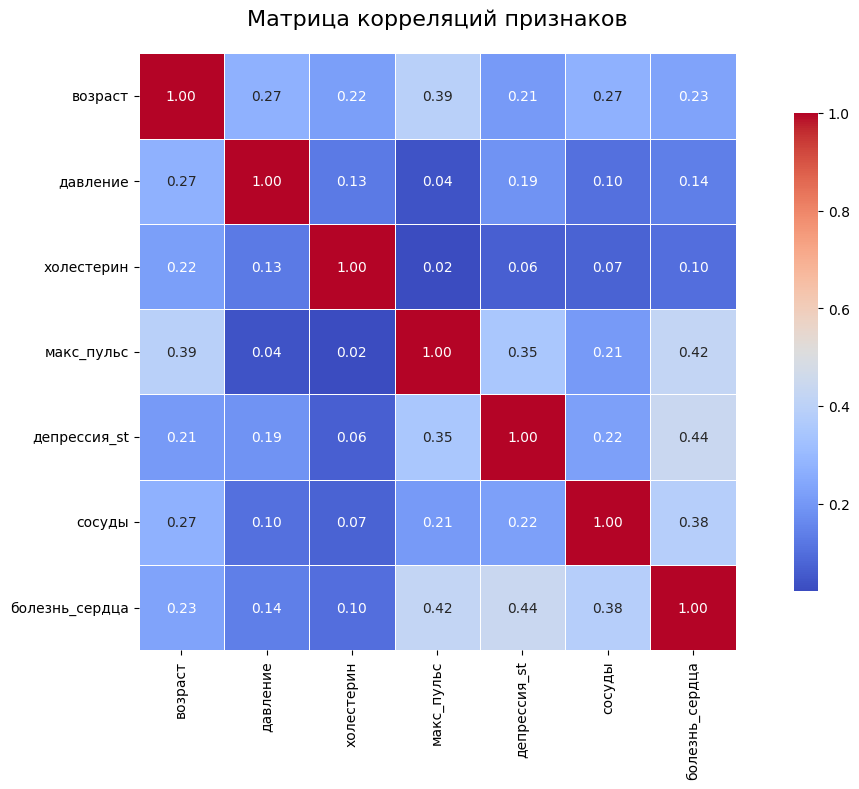

Удаляем слабо коррелирующие признаки: ['холестерин']


In [20]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(
    correlation_matrix.abs(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Матрица корреляций признаков", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

weak_corr_threshold = 0.1
weak_correlations = correlation_matrix["болезнь_сердца"].abs()
features_to_drop = weak_correlations[
    weak_correlations < weak_corr_threshold
].index.tolist()
if "болезнь_сердца" in features_to_drop:
    features_to_drop.remove("болезнь_сердца")

if features_to_drop:
    print(f"Удаляем слабо коррелирующие признаки: {features_to_drop}")
    df = df.drop(features_to_drop, axis=1)

## Подготовка данных

In [21]:
target = "болезнь_сердца"
y = df[target]
X = df.drop([target], axis=1)

label_encoders = {}
for col in X.select_dtypes(include=["category"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print("\nРаспределение классов:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Распределение классов:
болезнь_сердца
1    0.513171
0    0.486829
Name: proportion, dtype: float64


# Модель

## База


ОБУЧЕНИЕ БАЗОВОЙ МОДЕЛИ

Метрики базовой модели:
Accuracy: 0.8366
Precision: 0.8375
Recall: 0.8366

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       125
           1       0.86      0.82      0.84       132

    accuracy                           0.84       257
   macro avg       0.84      0.84      0.84       257
weighted avg       0.84      0.84      0.84       257



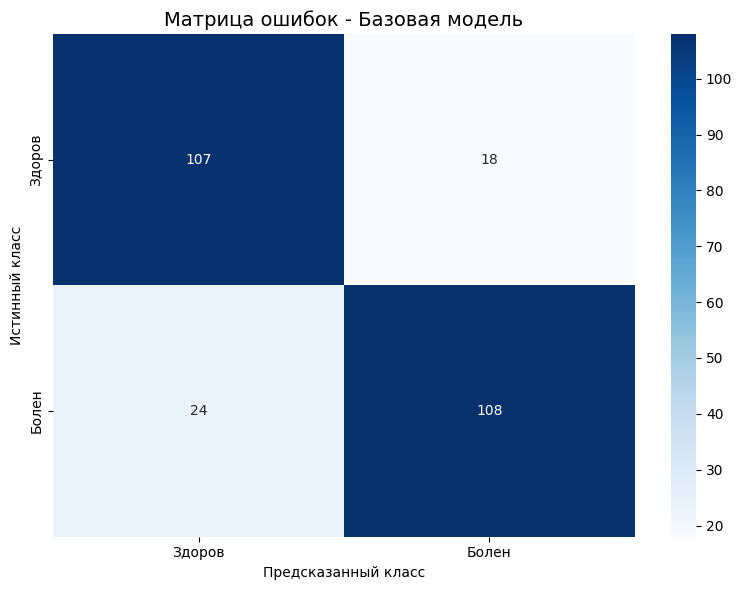

In [22]:

## Базовая модель
print("\n" + "=" * 50)
print("ОБУЧЕНИЕ БАЗОВОЙ МОДЕЛИ")
print("=" * 50)

base_model = DecisionTreeClassifier(max_depth=4, random_state=SEED)
base_model.fit(X_train_scaled, y_train)

# Оценка базовой модели
y_pred_base = base_model.predict(X_test_scaled)

print("\nМетрики базовой модели:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_base, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_base, average='weighted'):.4f}")

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_base))

# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Здоров", "Болен"],
    yticklabels=["Здоров", "Болен"],
)
plt.title("Матрица ошибок - Базовая модель", fontsize=14)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.tight_layout()
plt.show()


## SMOTE

In [23]:
print("\n" + "=" * 50)
print("БАЛАНСИРОВКА КЛАССОВ И СИНТЕТИЧЕСКИЕ ДАННЫЕ")
print("=" * 50)

# Применяем SMOTE
smote = SMOTE(random_state=SEED, k_neighbors=3)
X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"До балансировки: {pd.Series(y_train).value_counts().to_dict()}")
print(f"После SMOTE: {pd.Series(y_balanced).value_counts().to_dict()}")

balanced_df = pd.DataFrame(X_balanced, columns=X.columns)
balanced_df[target] = y_balanced

synthetic_dfs = []
for class_value in balanced_df[target].unique():
    class_data = balanced_df[balanced_df[target] == class_value]

    if len(class_data) > 15:
        class_metadata = SingleTableMetadata()
        class_metadata.detect_from_dataframe(class_data)

        synthesizer = GaussianCopulaSynthesizer(class_metadata)
        synthesizer.fit(class_data)

        samples_needed = max(0, 100 - len(class_data))
        if samples_needed > 0:
            synthetic_class = synthesizer.sample(num_rows=samples_needed)
            synthetic_dfs.append(synthetic_class)

if synthetic_dfs:
    synthetic_dfs.append(balanced_df)
    enhanced_df = pd.concat(synthetic_dfs, ignore_index=True)
    X_enhanced = enhanced_df.drop(target, axis=1)
    y_enhanced = enhanced_df[target]
else:
    X_enhanced = X_balanced
    y_enhanced = y_balanced

print(f"\nРазмер расширенного набора данных: {len(X_enhanced)}")


БАЛАНСИРОВКА КЛАССОВ И СИНТЕТИЧЕСКИЕ ДАННЫЕ
До балансировки: {1: 394, 0: 374}
После SMOTE: {1: 394, 0: 394}

Размер расширенного набора данных: 788


## Гиперпараметры

In [24]:
print("\n" + "=" * 50)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ")
print("=" * 50)

param_grid = {
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2", None],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=SEED),
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_enhanced, y_enhanced)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
best_model.fit(X_enhanced, y_enhanced)



ПОДБОР ГИПЕРПАРАМЕТРОВ
Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший F1-score: 0.9263


,criterion,'entropy'
,splitter,'best'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Оценка


ОЦЕНКА УЛУЧШЕННОЙ МОДЕЛИ

Метрики улучшенной модели:
Accuracy: 0.9416
Precision: 0.9418
Recall: 0.9416

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       125
           1       0.93      0.95      0.94       132

    accuracy                           0.94       257
   macro avg       0.94      0.94      0.94       257
weighted avg       0.94      0.94      0.94       257


Сравнение моделей:
     Метрика  Базовая модель  Улучшенная модель
0   Accuracy        0.836576           0.941634
1  Precision        0.837518           0.941838
2     Recall        0.836576           0.941634


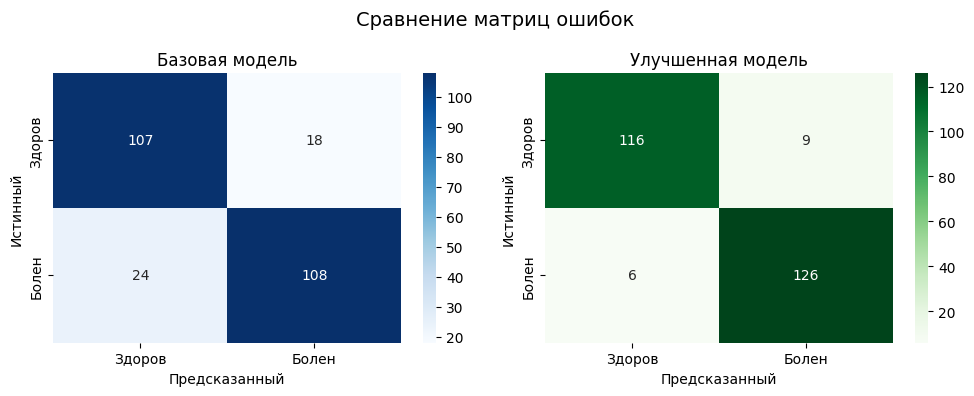

In [25]:
print("\n" + "=" * 50)
print("ОЦЕНКА УЛУЧШЕННОЙ МОДЕЛИ")
print("=" * 50)

y_pred_enhanced = best_model.predict(X_test_scaled)

print("\nМетрики улучшенной модели:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_enhanced):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_enhanced, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_enhanced, average='weighted'):.4f}")

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred_enhanced))

comparison = pd.DataFrame(
    {
        "Метрика": ["Accuracy", "Precision", "Recall"],
        "Базовая модель": [
            accuracy_score(y_test, y_pred_base),
            precision_score(y_test, y_pred_base, average="weighted"),
            recall_score(y_test, y_pred_base, average="weighted"),
        ],
        "Улучшенная модель": [
            accuracy_score(y_test, y_pred_enhanced),
            precision_score(y_test, y_pred_enhanced, average="weighted"),
            recall_score(y_test, y_pred_enhanced, average="weighted"),
        ],
    }
)

print("\nСравнение моделей:")
print(comparison)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm_base = confusion_matrix(y_test, y_pred_base)
sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Здоров", "Болен"],
    yticklabels=["Здоров", "Болен"],
)
plt.title("Базовая модель")
plt.xlabel("Предсказанный")
plt.ylabel("Истинный")

plt.subplot(1, 2, 2)
cm_enhanced = confusion_matrix(y_test, y_pred_enhanced)
sns.heatmap(
    cm_enhanced,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["Здоров", "Болен"],
    yticklabels=["Здоров", "Болен"],
)
plt.title("Улучшенная модель")
plt.xlabel("Предсказанный")
plt.ylabel("Истинный")

plt.suptitle("Сравнение матриц ошибок", fontsize=14)
plt.tight_layout()
plt.show()

## Дерево решений


ВИЗУАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ

Правила дерева решений:
|--- тип_боли <= -0.42
|   |--- сосуды <= -0.25
|   |   |--- талассемия <= 0.26
|   |   |   |--- стенокардия <= 0.35
|   |   |   |   |--- возраст <= 0.59
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- возраст >  0.59
|   |   |   |   |   |--- депрессия_st <= 0.02
|   |   |   |   |   |   |--- макс_пульс <= 0.73
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- макс_пульс >  0.73
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- депрессия_st >  0.02
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- стенокардия >  0.35
|   |   |   |   |--- макс_пульс <= -0.15
|   |   |   |   |   |--- давление <= -0.97
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- давление >  -0.97
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- макс_пульс >  -0.15
|   |   |   |   |   |--- депрессия_st <= -0.23
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- депрессия_st >  -0.2

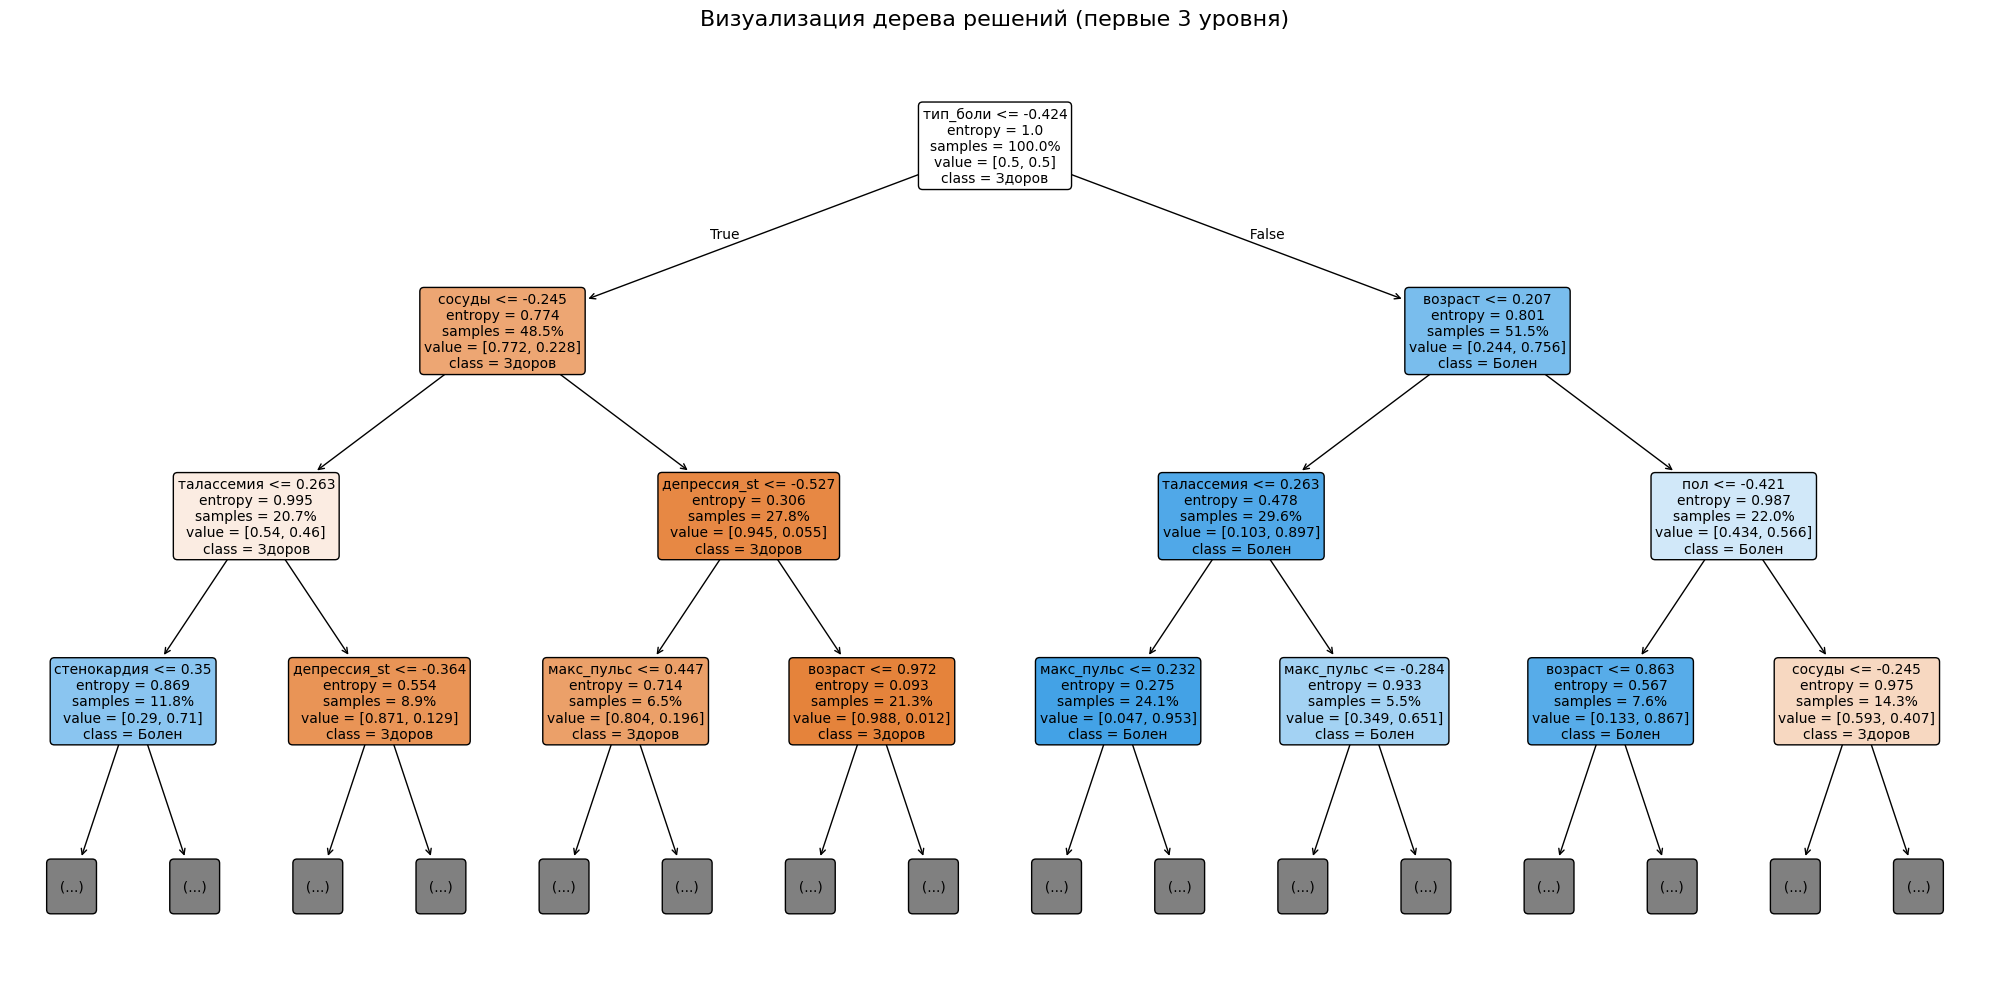

In [26]:
print("\n" + "=" * 50)
print("ВИЗУАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ")
print("=" * 50)

print("\nПравила дерева решений:")
tree_rules = export_text(best_model, feature_names=list(X.columns))
print(tree_rules)

plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=X.columns.tolist(),
    class_names=["Здоров", "Болен"],
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=True,
    max_depth=3,
)
plt.title("Визуализация дерева решений (первые 3 уровня)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Анализ важности признаков


Важность признаков:
         Признак  Важность
2       тип_боли  0.233871
10        сосуды  0.143735
0        возраст  0.142472
6     макс_пульс  0.135369
8   депрессия_st  0.092595
11    талассемия  0.086520
1            пол  0.056793
3       давление  0.036957
5            экг  0.035694
7    стенокардия  0.024833
9      наклон_st  0.011160
4    сахар_крови  0.000000


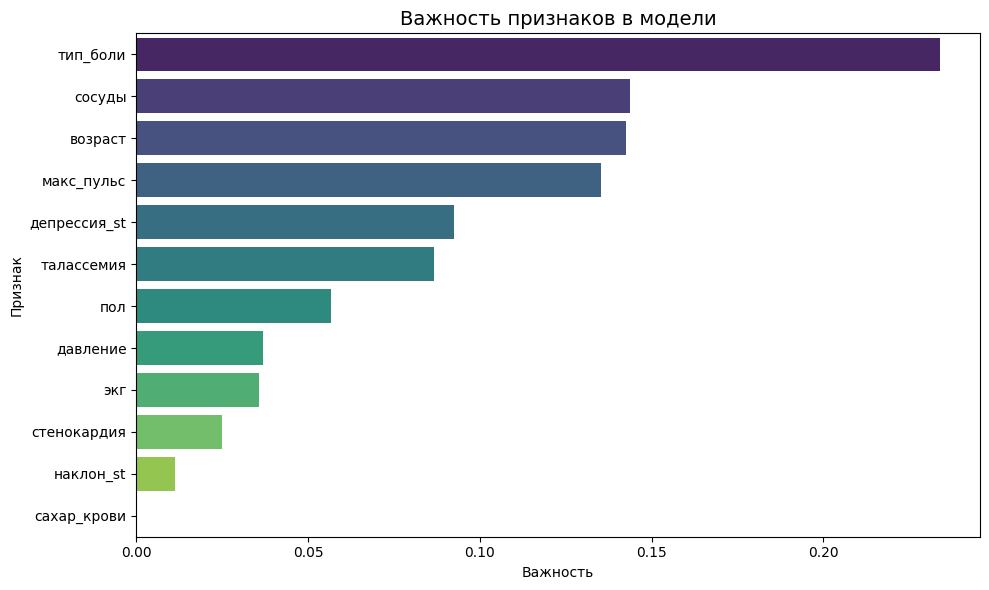

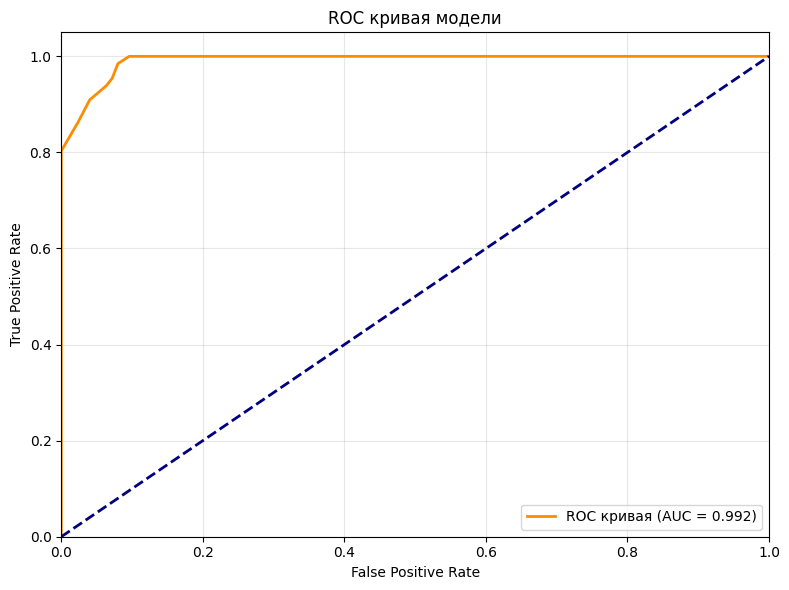


АНАЛИЗ ЗАВЕРШЕН
Итоговая точность модели: 0.9416
Улучшение точности: 0.1051


In [27]:
feature_importance = pd.DataFrame(
    {"Признак": X.columns, "Важность": best_model.feature_importances_}
).sort_values("Важность", ascending=False)

print("\nВажность признаков:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x="Важность", y="Признак", palette="viridis")
plt.title("Важность признаков в модели", fontsize=14)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()


if hasattr(best_model, "predict_proba"):
    y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC кривая (AUC = {roc_auc:.3f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC кривая модели")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n" + "=" * 50)
print("АНАЛИЗ ЗАВЕРШЕН")
print("=" * 50)
print(f"Итоговая точность модели: {accuracy_score(y_test, y_pred_enhanced):.4f}")
print(
    f"Улучшение точности: {accuracy_score(y_test, y_pred_enhanced) - accuracy_score(y_test, y_pred_base):.4f}"
)